I0000 00:00:1759646184.436526 6774188 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1759646184.436609 6774188 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.2049 - mae: 0.3652 - val_loss: 0.0392 - val_mae: 0.1563
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0519 - mae: 0.1790 - val_loss: 0.0293 - val_mae: 0.1407
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0350 - mae: 0.1469 - val_loss: 0.0192 - val_mae: 0.1093
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0245 - mae: 0.1235 - val_loss: 0.0198 - val_mae: 0.1137
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0210 - mae: 0.1142 - val_loss: 0.0136 - val_mae: 0.0914
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0226 - mae: 0.1188 - val_loss: 0.0165 - val_mae: 0.1022
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0182 - mae: 0.1056 - val_loss: 0.0250 - val_mae: 0.1295
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0188 - mae: 0.1078 - val_loss: 0.0175 - val_mae: 0.1066
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - l

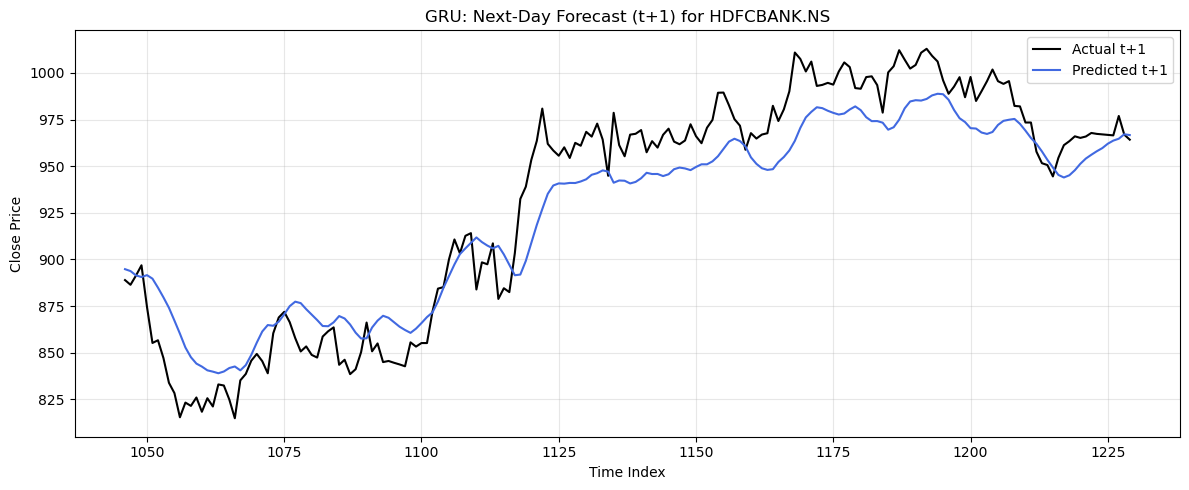

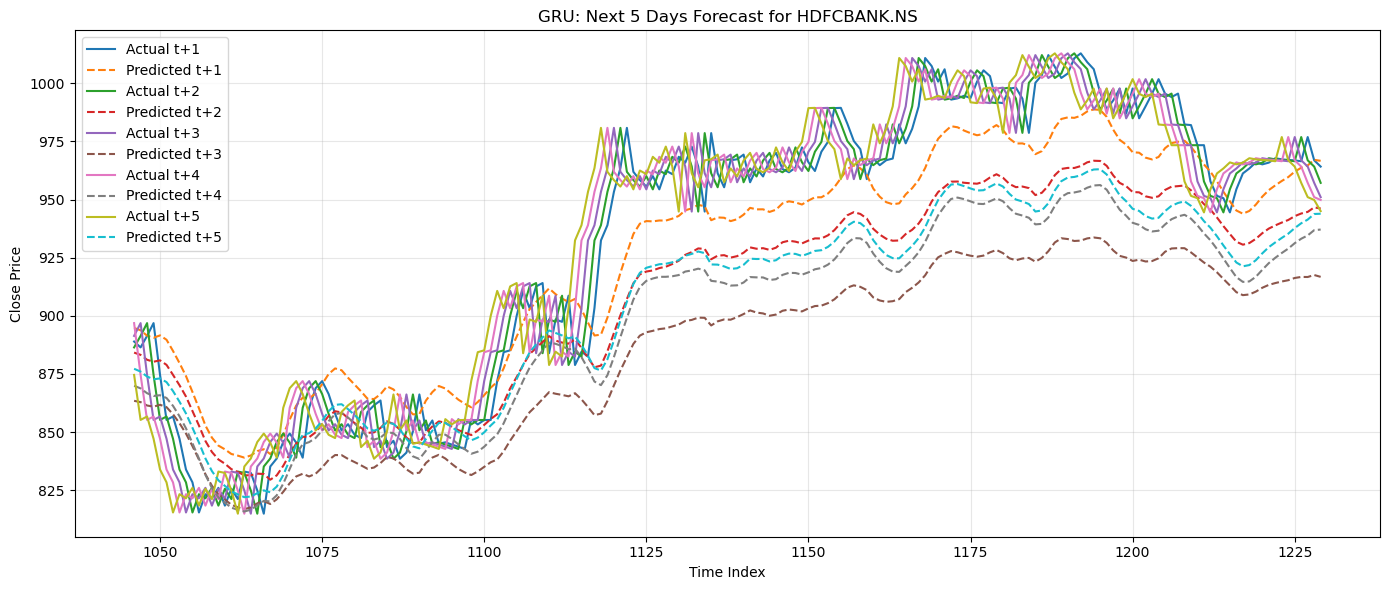

In [12]:
# notebooks/GRU_10day_forecast.py
import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, Model

# -----------------------------
# Config
# -----------------------------
TARGET = "Close"
SEQ_LEN = 25
PRED_HORIZON = 10
VAL_FRAC = 0.15
TEST_FRAC = 0.15
RANDOM_SEED = 42
EMBEDDING_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3

data_dir = "../Data"
ticker = "HDFCBANK.NS"
DATA_CSV = os.path.join(data_dir, f"{ticker}_features.csv")

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.makedirs(os.path.join(data_dir, "embeddings"), exist_ok=True)

# -----------------------------
# Optional indicators (if missing)
# -----------------------------
def ema(series: pd.Series, span: int) -> pd.Series:
    k = 2 / (span + 1)
    return series.ewm(alpha=k, adjust=False).mean()

def wilder_ema(series: pd.Series, period: int) -> pd.Series:
    return series.ewm(alpha=1/period, adjust=False).mean()

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_up = wilder_ema(up, period)
    avg_down = wilder_ema(down, period)
    rs = avg_up / (avg_down.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(0)

def macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = ema(close, fast)
    ema_slow = ema(close, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def atr_wilder(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return wilder_ema(tr, period)

def stochastic_oscillator(df: pd.DataFrame, k_period=14, d_period=3):
    low_min = df['Low'].rolling(k_period).min()
    high_max = df['High'].rolling(k_period).max()
    k = 100 * (df['Close'] - low_min) / (high_max - low_min)
    d = k.rolling(d_period).mean()
    return k.fillna(50), d.fillna(50)

def obv(df: pd.DataFrame):
    obv_series = np.zeros(len(df))
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            obv_series[i] = obv_series[i-1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            obv_series[i] = obv_series[i-1] - df['Volume'].iloc[i]
        else:
            obv_series[i] = obv_series[i-1]
    return pd.Series(obv_series, index=df.index)

# -----------------------------
# Load CSV and build features
# -----------------------------
df = pd.read_csv(DATA_CSV)
df.rename(columns={c: c.title() for c in df.columns}, inplace=True)
features = df.copy()

features = features[['Open','High','Low','Close','Volume']].dropna().reset_index(drop=True)
features['LogRet'] = np.log(features['Close']).diff().fillna(0.0)
features['RSI14'] = rsi_wilder(features['Close'], 14)
m, s, h = macd(features['Close'])
features['MACD'] = m
features['MACD_SIGNAL'] = s
features['MACD_HIST'] = h
features['ATR14'] = atr_wilder(features['High'], features['Low'], features['Close'], 14)
features['EMA5'] = ema(features['Close'], 5)
features['EMA10'] = ema(features['Close'], 10)
features['STOCH_K'], features['STOCH_D'] = stochastic_oscillator(features)
features['OBV'] = obv(features)
features = features.dropna().reset_index(drop=True)

# Target: next 10 days Close
target = pd.DataFrame()
for i in range(1, PRED_HORIZON+1):
    target[f'Close_t+{i}'] = features['Close'].shift(-i)
target = target.dropna().reset_index(drop=True)
features = features.iloc[:-PRED_HORIZON, :].reset_index(drop=True)

# -----------------------------
# Train/Val/Test split
# -----------------------------
n = len(features)
test_size = int(math.floor(TEST_FRAC * n))
val_size = int(math.floor(VAL_FRAC * n))
train_size = n - val_size - test_size

X_all = features.values
y_all = target.values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_s = scaler_X.fit_transform(X_all[:train_size])
X_val_s   = scaler_X.transform(X_all[train_size:train_size+val_size])
X_test_s  = scaler_X.transform(X_all[train_size+val_size:])

y_train_s = scaler_y.fit_transform(y_all[:train_size])
y_val_s   = scaler_y.transform(y_all[train_size:train_size+val_size])
y_test_s  = scaler_y.transform(y_all[train_size+val_size:])

# -----------------------------
# Sequence creation
# -----------------------------
def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(Xs), np.array(ys)

Xtr, ytr = make_sequences(X_train_s, y_train_s, SEQ_LEN)
Xva, yva = make_sequences(np.vstack([X_train_s[-(SEQ_LEN-1):], X_val_s]),
                          np.vstack([y_train_s[-(SEQ_LEN-1):], y_val_s]), SEQ_LEN)
Xte, yte = make_sequences(np.vstack([X_val_s[-(SEQ_LEN-1):], X_test_s]),
                          np.vstack([y_val_s[-(SEQ_LEN-1):], y_test_s]), SEQ_LEN)

# Index for plotting
test_plot_index = np.arange(train_size + val_size, train_size + val_size + len(yte))

# -----------------------------
# GRU model
# -----------------------------
inp = layers.Input(shape=(SEQ_LEN, Xtr.shape[-1]))
x = layers.GRU(128, return_sequences=True)(inp)
x = layers.Dropout(0.2)(x)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.GRU(64, return_sequences=False)(x)
x = layers.Dropout(0.2)(x)
embedding = layers.Dense(EMBEDDING_SIZE, activation='relu', name='gru_embedding')(x)
out = layers.Dense(PRED_HORIZON, activation='linear')(embedding)

model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='mse', metrics=['mae'])

# -----------------------------
# Train
# -----------------------------
cbs = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
hist = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cbs, verbose=1)

# -----------------------------
# Predictions
# -----------------------------
y_pred_s = model.predict(Xte, batch_size=256)
y_pred = scaler_y.inverse_transform(y_pred_s)
y_true = scaler_y.inverse_transform(yte)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mse)
print(f"MSE={mse:.6f}  RMSE={rmse:.6f}  MAE={mae:.6f}")

# -----------------------------
# Save embeddings
# -----------------------------
embedding_model = Model(inputs=model.input, outputs=model.get_layer('gru_embedding').output)
embeddings = embedding_model.predict(np.vstack([Xtr, Xva, Xte]))
np.save(os.path.join(data_dir, "embeddings", f"{ticker}_gru_embeddings.npy"), embeddings)
print(f"Saved embeddings in {data_dir}/embeddings/")

# -----------------------------
# Plot first predicted horizon (t+1)
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(test_plot_index, y_true[:,0], label="Actual t+1", color='black', linewidth=1.5)
plt.plot(test_plot_index, y_pred[:,0], label="Predicted t+1", color='royalblue', linewidth=1.5)
plt.title(f"GRU: Next-Day Forecast (t+1) for {ticker}")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot first 5 predicted horizons
# -----------------------------
plt.figure(figsize=(14,6))
for i in range(min(PRED_HORIZON,5)):
    plt.plot(test_plot_index, y_true[:,i], label=f"Actual t+{i+1}")
    plt.plot(test_plot_index, y_pred[:,i], linestyle='--', label=f"Predicted t+{i+1}")
plt.title(f"GRU: Next {min(PRED_HORIZON,5)} Days Forecast for {ticker}")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
